# Proxy Composites using CFR package

Let's create proxy composites from the PAGES2k database using the GraphDB.

In [1]:
import json
import requests
import pandas as pd
import io
import ast
import numpy as np
import cfr as cfr

## PAGES2k

### Query the GraphDB for the temperature sensitive timeseries from PAGES2k

In [2]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse'

query = """PREFIX le: <http://linked.earth/ontology#>
select ?dsname ?val ?timeval ?archive ?pages2kID ?timeunits ?varname ?varunits ?lat ?lon ?alt ?proxysensor ?proxyobs ?timevarname FROM <http://linked.earth/lipd/Pages2k2_1_2> where { 
	VALUES ?timevarname {"year" "age"}
    ?ds  le:includesPaleoData ?data .
    ?ds le:name ?dsname .
    ?ds le:hasUrl ?url .
    ?ds  le:collectedFrom ?loc .
    ?loc le:wgs84_Lat ?lat .
    ?loc le:wgs84_Long ?lon .
    ?loc le:wgs84_Alt ?alt .
	?data le:foundInMeasurementTable ?table .
	?table le:includesVariable ?var .
    ?var le:useInGlobalTemperatureAnalysis true .
    ?var le:hasValues ?val .
    ?var le:name ?varname . 
    ?var le:hasUnits ?varunits .
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?timevarname .
    ?timevar le:hasValues ?timeval .
    ?ds le:proxyArchiveType ?archive .
    ?timevar le:hasUnits ?timeunits .
    ?var le:hasProxySystem ?proxysystem .
    ?proxysystem le:proxySensorType ?proxysensor .
    ?proxysystem le:proxyObservationType ?proxyobs .
    ?var le:pages2kID ?pages2kID .
}"""


response = requests.post(url, data = {'query': query})
data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

# Make list from the values string
df['val']=df['val'].apply(lambda row : ast.literal_eval(row))
df['timeval']=df['timeval'].apply(lambda row : ast.literal_eval(row))

df.head()

,dsname,val,timeval,archive,pages2kID,timeunits,varname,varunits,lat,lon,alt,proxysensor,proxyobs,timevarname
0,Ant-WDC05A.Steig.2013,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...","[2005, 2004, 2003, 2002, 2001, 2000, 1999, 199...",glacier ice,Ant_006,AD,d18O,permil,-79.46,-112.09,1806.0,D18ODefaultSensor,D18O,year
1,Ocn-Mayotte.Zinke.2008,"[-4.72, -4.95, -5.45, -5.157, -5.05, -5.065, -...","[1993.62, 1993.46, 1993.29, 1993.12, 1992.96, ...",coral,Ocn_139,AD,d18O,permil,-12.65,45.10,-3.0,Porites porites lutea,D18O,year
2,Ocn-Mayotte.Zinke.2008,"[8.6, 8.701, 8.802, 8.84, 8.877, 8.804, 8.588,...","[1994.29, 1994.12, 1993.96, 1993.79, 1993.62, ...",coral,Ocn_061,AD,Sr_Ca,mmol/mol,-12.65,45.10,-3.0,Porites porites lutea,Sr/Ca,year
3,Ocn-Mayotte.Zinke.2008,"[0.534, 0.535, 0.721, 0.614, 0.458, 0.033, 0.3...","[1993.62, 1993.46, 1993.29, 1993.12, 1992.96, ...",coral,Ocn_062,AD,d18O,permil,-12.65,45.10,-3.0,Porites porites lutea,D18O,year
4,Ocn-LosRoques.Hetzinger.2008,"[-3.8123, -3.73082, -3.74912, -3.6656, -3.6995...","[1917.79, 1917.87, 1917.96, 1918.04, 1918.12, ...",coral,Ocn_147,AD,d18O,permil,11.77,-66.75,-2.0,Diploria diploria strigosa,D18O,year


In [3]:
set(df['timevarname']) #ask Varun

{'year'}

Clean up for use with cfr 

**Note**: This is going to be very specific to each database

In [4]:
clean_name = []

for idx,row in df.iterrows():
    if row['proxyobs']=='D18O' or row['proxyobs']=='ForamD18O':
        clean_name.append('d18O')
    elif row['proxyobs']=='Sr_Ca':
        clean_name.append('SrCa')
    elif row['proxyobs']=='Mg_Ca':
        clean_name.append('MgCa')
    elif row['proxyobs']=='DD':
        clean_name.append('dD')
    elif row['proxyobs']=='Melt' or row['proxyobs']=='Calcification':
        clean_name.append(row['proxyobs'].lower())
    elif row['proxyobs']=='CalcificationRate':
        clean_name.append('calcification rate')
    elif row['proxyobs']=='VarveThickness':
        clean_name.append('varve thickness')
    elif row['proxyobs']=='SedAccumulation':
        clean_name.append('sed accumulation')
    else: 
        clean_name.append(row['proxyobs'])

df['proxy_name']=clean_name        
df.head()

,dsname,val,timeval,archive,pages2kID,timeunits,varname,varunits,lat,lon,alt,proxysensor,proxyobs,timevarname,proxy_name
0,Ant-WDC05A.Steig.2013,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...","[2005, 2004, 2003, 2002, 2001, 2000, 1999, 199...",glacier ice,Ant_006,AD,d18O,permil,-79.46,-112.09,1806.0,D18ODefaultSensor,D18O,year,d18O
1,Ocn-Mayotte.Zinke.2008,"[-4.72, -4.95, -5.45, -5.157, -5.05, -5.065, -...","[1993.62, 1993.46, 1993.29, 1993.12, 1992.96, ...",coral,Ocn_139,AD,d18O,permil,-12.65,45.10,-3.0,Porites porites lutea,D18O,year,d18O
2,Ocn-Mayotte.Zinke.2008,"[8.6, 8.701, 8.802, 8.84, 8.877, 8.804, 8.588,...","[1994.29, 1994.12, 1993.96, 1993.79, 1993.62, ...",coral,Ocn_061,AD,Sr_Ca,mmol/mol,-12.65,45.10,-3.0,Porites porites lutea,Sr/Ca,year,Sr/Ca
3,Ocn-Mayotte.Zinke.2008,"[0.534, 0.535, 0.721, 0.614, 0.458, 0.033, 0.3...","[1993.62, 1993.46, 1993.29, 1993.12, 1992.96, ...",coral,Ocn_062,AD,d18O,permil,-12.65,45.10,-3.0,Porites porites lutea,D18O,year,d18O
4,Ocn-LosRoques.Hetzinger.2008,"[-3.8123, -3.73082, -3.74912, -3.6656, -3.6995...","[1917.79, 1917.87, 1917.96, 1918.04, 1918.12, ...",coral,Ocn_147,AD,d18O,permil,11.77,-66.75,-2.0,Diploria diploria strigosa,D18O,year,d18O


### Create a ProxyDatabase with cfr

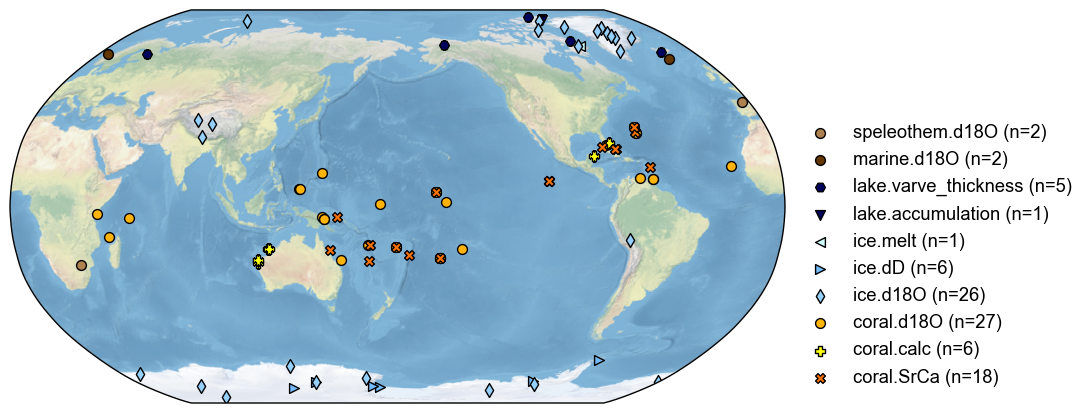

In [5]:
pdb = cfr.ProxyDatabase().from_df(df,
                                  pid_column='dsname',
                                  lat_column='lat',
                                  lon_column='lon',
                                  time_column='timeval',
                                  value_column='val',
                                  proxy_type_column='proxy_name',
                                  archive_type_column='archive',
                                  value_name_column='varname',
                                  value_unit_column='varunits')
                                  
fig, ax = pdb.plot()

### Create a composite for each archivetype

First, create a list of the possible archive types stored in the ProxyDataBase

In [6]:
type_list = pdb.type_list
proxy_type = []

for i in type_list:
    if i.split('.')[0] in proxy_type:
        pass
    else:
        proxy_type.append(i.split('.')[0])

Load instrumental temperature observations as a target for scaling the proxy values.

In [7]:
import xarray as xr

ds = xr.open_dataset('./data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
ds

<xarray.Dataset>
Dimensions:           (time: 2071, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-07-1...
  * latitude          (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude         (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (latitude, bnds) float64 ...
    longitude_bnds    (longitude, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2022-09-06T13:35:49+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

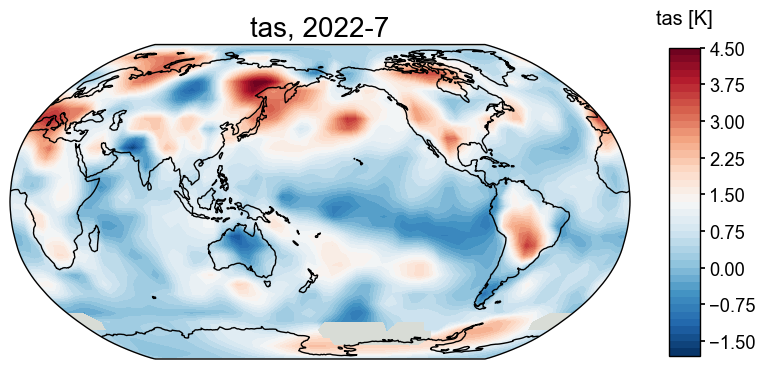

In [8]:
obs = cfr.ClimateField().load_nc(
    './data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc',
    vn='tas_mean', lat_name='latitude', lon_name='longitude',
)
obs = obs.rename('tas')
fig, ax = obs.plot(it=-1) #(optional plot)

Analyzing ProxyRecord:   3%|▋                    | 1/33 [00:00<00:05,  6.04it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:  18%|███▊                 | 6/33 [00:00<00:01, 25.57it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:  36%|███████▎            | 12/33 [00:00<00:00, 38.23it/s]/Users/debor

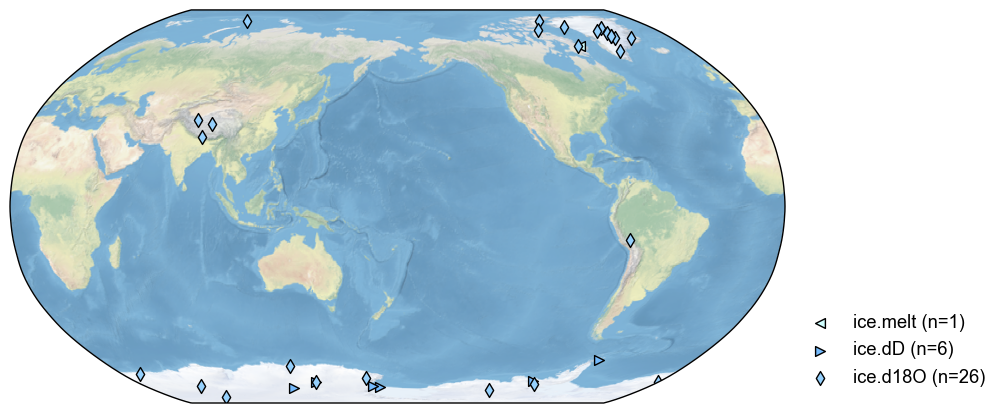

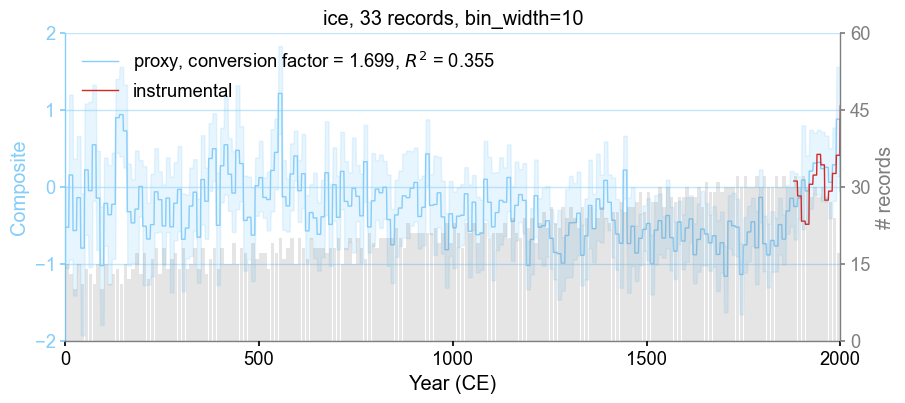

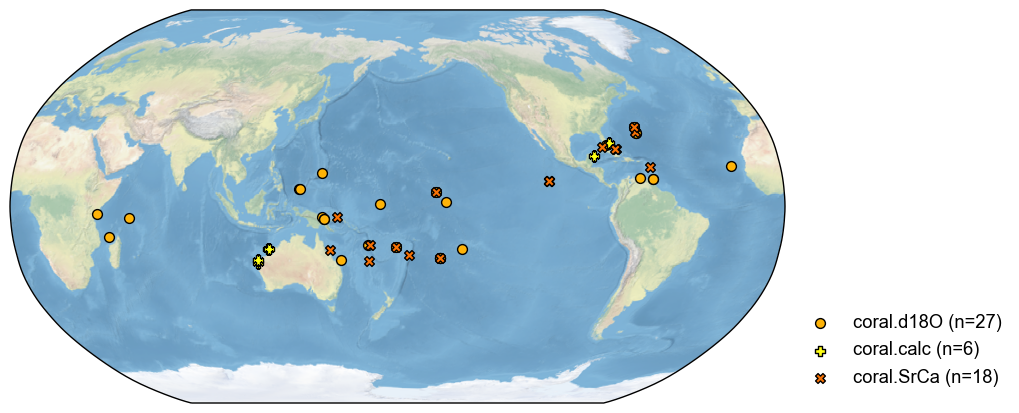

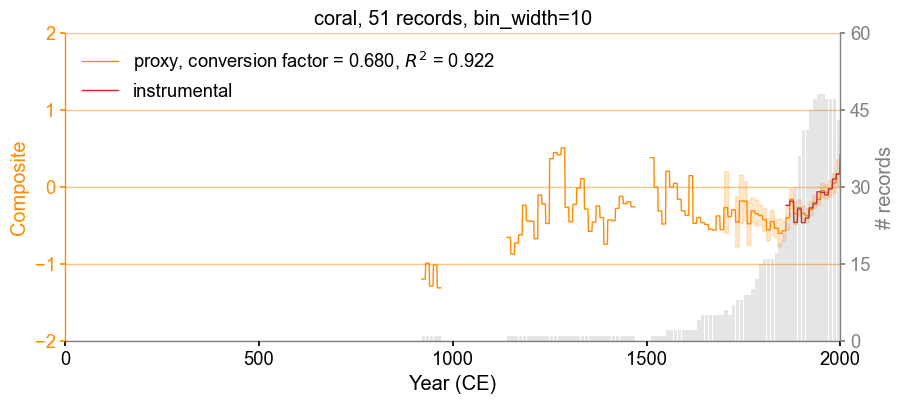

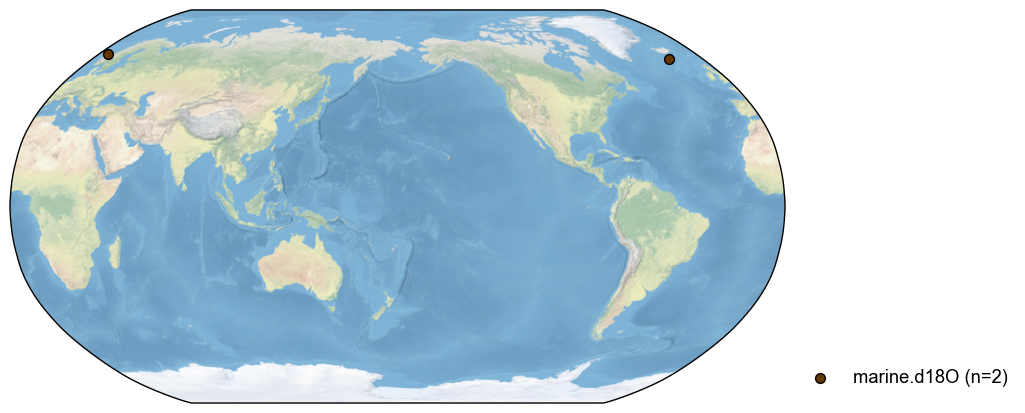

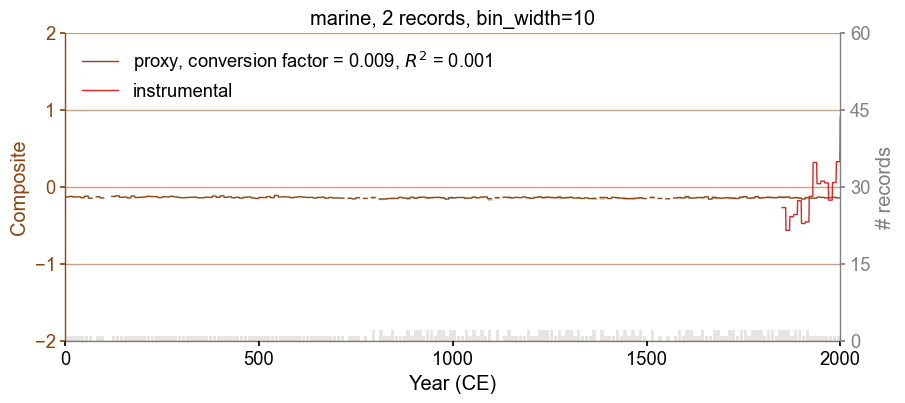

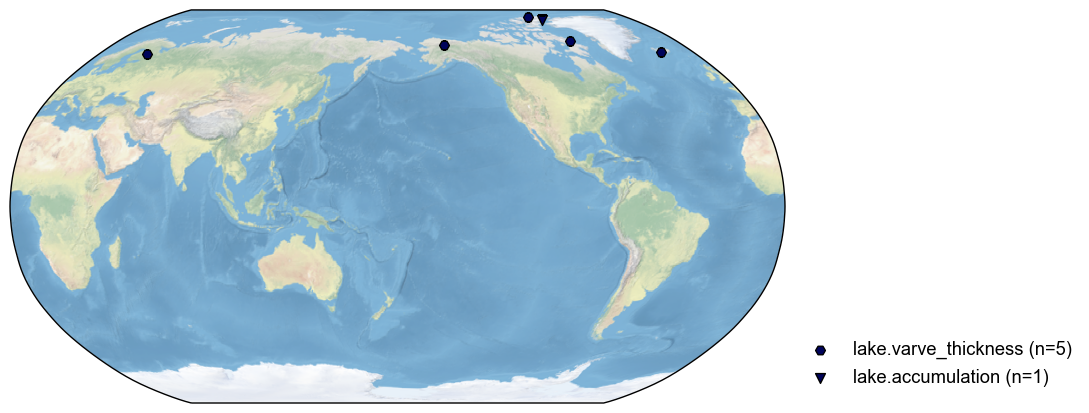

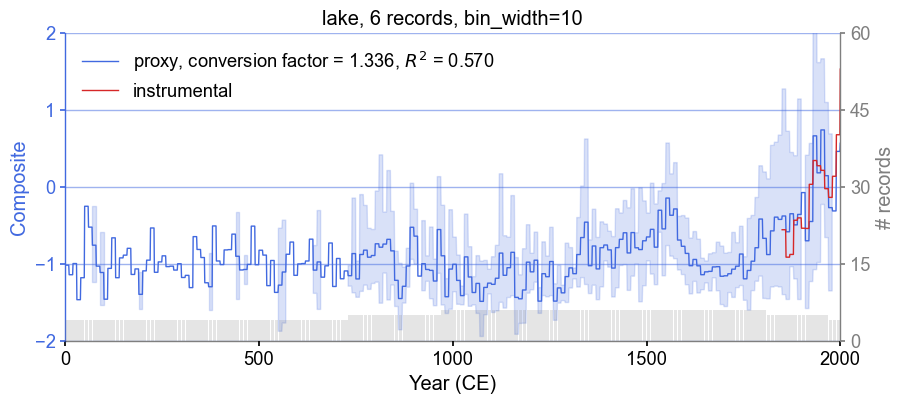

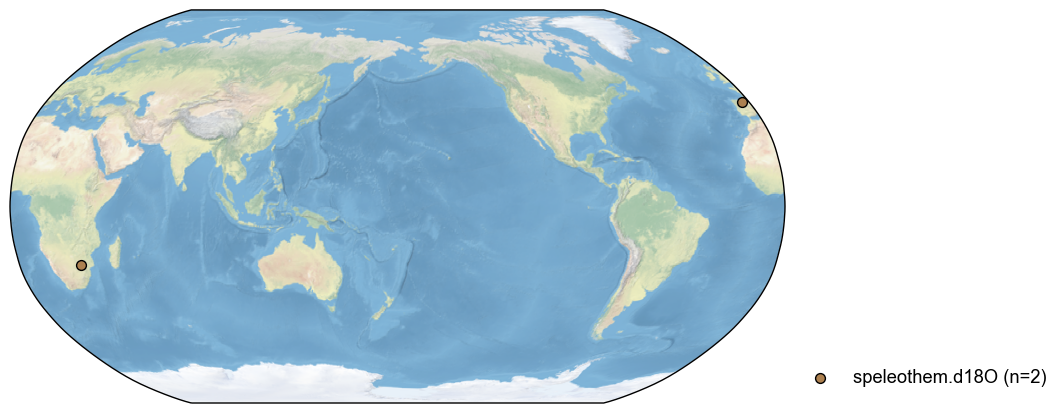

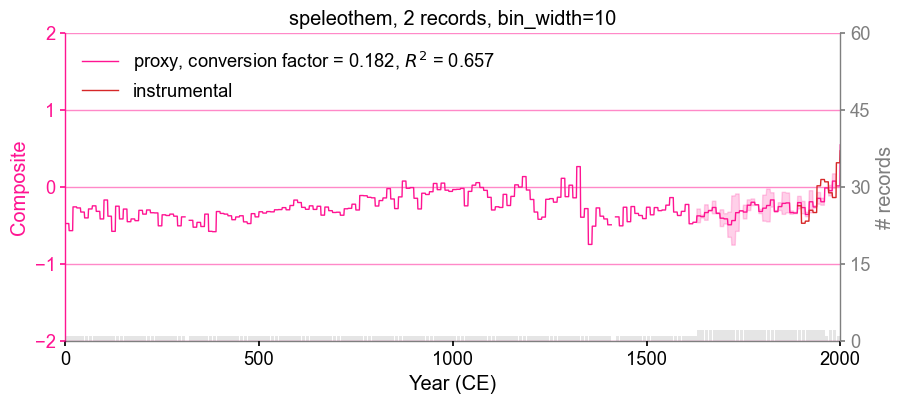

In [10]:
for item in proxy_type:

    pdb_proxytype = pdb.filter(by='ptype', keys=item)
    fig, ax = pdb_proxytype.plot()

    pdb_proxytype.make_composite(obs=obs)
    fig, ax = pdb_proxytype.plot_composite()

## Iso2k database

### Query the GraphDB for the temperature sensitive timeseries from ISO2k

In [ ]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse'

query = """PREFIX le: <http://linked.earth/ontology#>
select ?dsname ?val ?timeval ?archive ?pages2kID ?timeunits ?varname ?varunits ?lat ?lon ?alt ?proxysensor ?proxyobs ?timevarname FROM <http://linked.earth/lipd/Pages2k2_1_2> where { 
	VALUES ?timevarname {"year" "age"}
    ?ds  le:includesPaleoData ?data .
    ?ds le:name ?dsname .
    ?ds le:hasUrl ?url .
    ?ds  le:collectedFrom ?loc .
    ?loc le:wgs84_Lat ?lat .
    ?loc le:wgs84_Long ?lon .
    ?loc le:wgs84_Alt ?alt .
	?data le:foundInMeasurementTable ?table .
	?table le:includesVariable ?var .
    ?var le:useInGlobalTemperatureAnalysis true .
    ?var le:hasValues ?val .
    ?var le:name ?varname . 
    ?var le:hasUnits ?varunits .
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?timevarname .
    ?timevar le:hasValues ?timeval .
    ?ds le:proxyArchiveType ?archive .
    ?timevar le:hasUnits ?timeunits .
    ?var le:hasProxySystem ?proxysystem .
    ?proxysystem le:proxySensorType ?proxysensor .
    ?proxysystem le:proxyObservationType ?proxyobs .
    ?var le:pages2kID ?pages2kID .
}"""


response = requests.post(url, data = {'query': query})
data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

# Make list from the values string
df['val']=df['val'].apply(lambda row : ast.literal_eval(row))
df['timeval']=df['timeval'].apply(lambda row : ast.literal_eval(row))

df.head()